In [2]:
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray, ycbcr2rgb, lab2rgb
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict
from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.transform import resize
import os

def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))

def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

def plot_images(images: Dict[str, np.ndarray], title=None, cmap=None):
    """Plots all images in a row""",
    fig = plt.figure(figsize=(10, 3))
    for index, (subtitle, image) in enumerate(images.items(), 1):
        ax = fig.add_subplot(1, len(images), index)
        if cmap is not None:
            ax.imshow(image, cmap=cmap)
        else:
            ax.imshow(image)
        ax.title.set_text(subtitle)
    if title:
        fig.suptitle(title)
    plt.show()
    

# Part 2 Chroma Subsampling

(384, 512, 3)


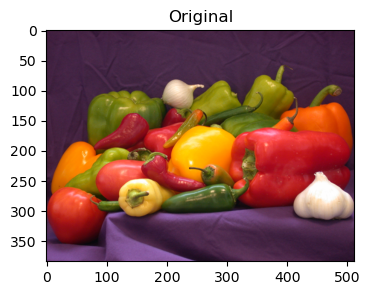

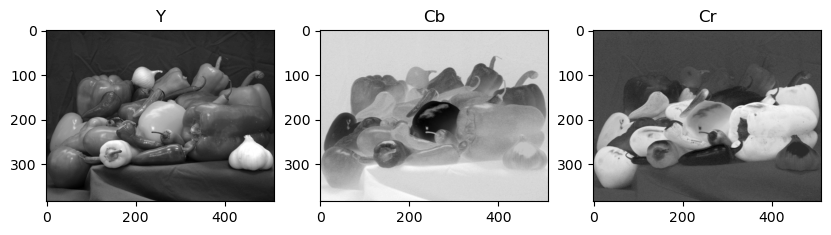

157.05463529411765 29.38563921568627


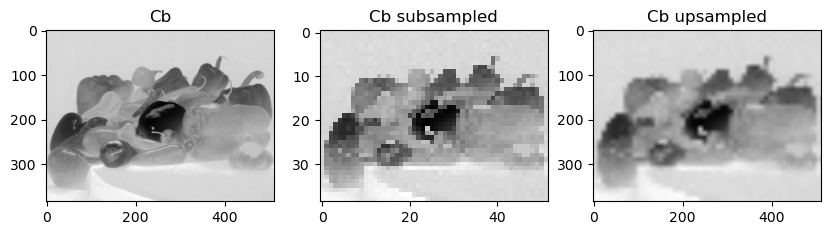

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


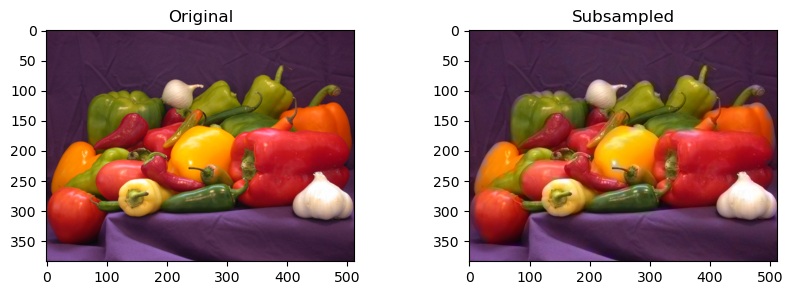

In [3]:
# code for chroma subsampling
# First, we will study the effects of chroma subsampling on image quality and how it can be used to provide
# image compression. For this study, we will use the peppers image. 

# First, let us convert the image from the RGB colorspace into the YCbCr colorspace using the rgb2ycbcr function from skimage.color. 
peppers = imread('peppers.png')
peppers_ycbcr = rgb2ycbcr(peppers)
print(peppers_ycbcr.shape)

plot_images({'Original': peppers})

# Plot each of the image channels (Y, Cb, and Cr) separately. eparate the color image into three separate images so you can operate on them independently. Make sure to scale the images to the range [0, 1].

y_channel = peppers_ycbcr[:, :, 0]
cb_channel = peppers_ycbcr[:, :, 1]
cr_channel = peppers_ycbcr[:, :, 2]

plot_images({'Y': y_channel, 'Cb': cb_channel, 'Cr': cr_channel}, cmap='gray')
print(cb_channel.max(), cb_channel.min())

# Now, reduce the resolution of the chroma channels by a factor of 2 in both the horizontal and vertical
# directions and then upsample them back to the original resolution using bilinear interpolation.
cb_channel_subsampled = cb_channel[::2, ::2]
cr_channel_subsampled = cr_channel[::2, ::2]

# upsample using the resize function from skimage.transform using bilinear interpolation.
cb_channel_upsampled = resize(cb_channel_subsampled, cb_channel.shape, order=1)
cr_channel_upsampled = resize(cr_channel_subsampled, cr_channel.shape, order=1)

plot_images({'Cb': cb_channel, 'Cb subsampled': cb_channel_subsampled, 'Cb upsampled': cb_channel_upsampled}, cmap='gray')

# Recombine the original Y channel image and the two upsampled Cb and Cr images to create a new color image.
# Make sure to convert the image back to the RGB colorspace using the ycbcr2rgb function from skimage.color.

peppers_recombined = np.zeros_like(peppers_ycbcr)
peppers_recombined[:, :, 0] = y_channel
peppers_recombined[:, :, 1] = cb_channel_upsampled
peppers_recombined[:, :, 2] = cr_channel_upsampled

peppers_recombined_rgb = ycbcr2rgb(peppers_recombined)

# print the new image
plot_images({'Original': peppers, 'Subsampled': peppers_recombined_rgb}, cmap='gray')

# Part 3 Colour Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


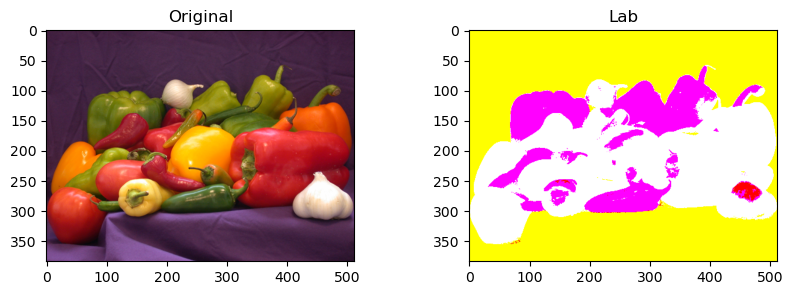

: 

In [4]:
# part 3 Colour Segmentation
# os.environ['OMP_NUM_THREADS'] = '1'
# OMP_NUM_THREADS=1
# 1. convert the image to the lab colorspace
lab_peppers = rgb2lab(peppers)
# 2. use kmeans to cluster the image into 2 and 4 clusters

k2 = 2
k4 = 4
plot_images({'Original': peppers, 'Lab': lab_peppers}, cmap=None)

# get the cluster centers
row2 = np.array([55, 200]) - 1
col2 = np.array([155, 400]) - 1
row4 = np.array([55, 130, 200, 280]) - 1
col4 = np.array([155, 110, 400, 470]) - 1
mu1 = lab_peppers[row2, col2]
mu2 = lab_peppers[row4, col4]
kmeans2 = KMeans(n_clusters=k2, n_init=10, random_state=0).fit(mu1)
kmeans4 = KMeans(n_clusters=k4, n_init=10, random_state=0).fit(mu2)

# reshape the image into a 2D array
m, n, ch = lab_peppers.shape
lab_peppers = np.reshape(lab_peppers, (m*n, ch), order='F')

# get the cluster indices
cluster2 = kmeans2.predict(lab_peppers)
cluster4 = kmeans4.predict(lab_peppers)

pixel_labels2 = np.reshape(cluster2, (m, n), order='F')
pixel_labels4 = np.reshape(cluster4, (m, n), order='F')


# plot with jet colormap, and title 'Image Labeled by cluster index'
plot_images({'2 clusters': pixel_labels2, '4 clusters': pixel_labels4}, title='Image Labeled by cluster index', cmap='jet')

# plot the segmented images

def plot_segments(image, k, row, col):
  image_lab = rgb2lab(image)
  mu = image_lab[row, col]

  for i in range(k):
    mu[i] = image_lab[row[i] - 1, col[i] -1]

  m, n, ch = image_lab.shape
  reshaped_image = np.reshape(image_lab, (m*n, ch), order='F')
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(mu)
  cluster = kmeans.predict(reshaped_image)
  pixel_labels = np.reshape(cluster, (m, n), order='F')

  segmented_images = {}

  for label in range(k):
    mask = (pixel_labels == label)
    masked_image = np.zeros_like(image)
    masked_image[mask] = image[mask]
    segmented_images[f'Segment {label+1}'] = masked_image


  plot_images(segmented_images, title='Segmented Images')

      

  
plot_segments(peppers, 4, row4, col4)





# I am not sure if the above instructions are correct. Please check and correct them if necessary.

# Part 4 Image Transform

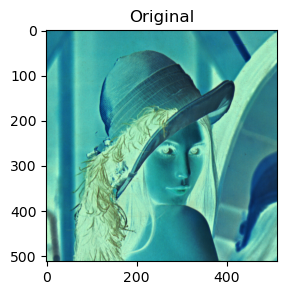

<Figure size 640x480 with 0 Axes>

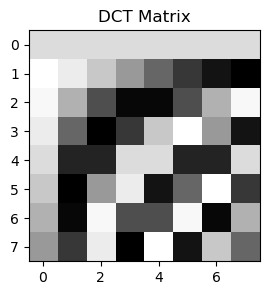

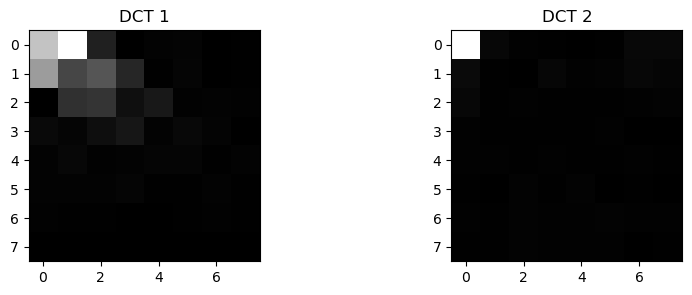

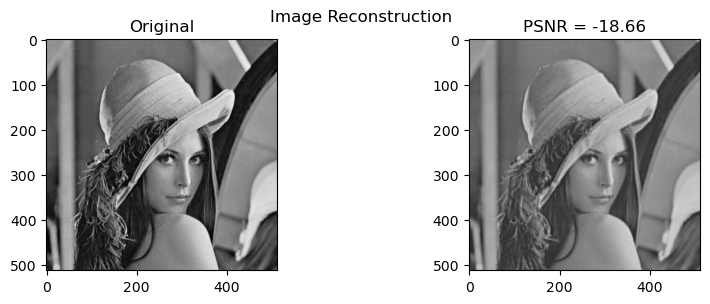

In [ ]:
# Part 4 Image Transform

# NOTE from cormo: make sure to scale the image (lena) by 255 after importing it
lena = imread('lena2.tiff') * 255
plot_images({'Original': lena})
plt.gray()
gray_lena = rgb2gray(imread('lena2.tiff')) * 255
# create an 8x8 dct matrix
dct_matrix = dctmtx(8)
plot_images({'DCT Matrix': dct_matrix})

lena_trans = np.floor(blockproc(gray_lena-128, dct_matrix, [8, 8], func))
# Plot the absolute value of the DCT of the 8×8 sub-image with top-left corner at (row,col) = (80,296
plot_images({'DCT 1': np.abs(lena_trans[80:88, 296:304]), 'DCT 2': np.abs(lena_trans[0:8, 0:8])})


mask = np.zeros((8, 8))
mask[0,0] = 1
mask[0,1] = 1
mask[0,2] = 1
mask[1,0] = 1
mask[1,1] = 1
mask[2,0] = 1

lena_thresh = blockproc(lena_trans, mask, [8, 8], func1)
lena_thresh_inv = np.floor(blockproc(lena_thresh, dct_matrix.T, [8, 8], func)) + 128

# plot the reconstructed image and the corresponding PSNR value
plot_images({'Original' : gray_lena, 'PSNR = ' + str(np.round(PSNR(gray_lena, lena_thresh_inv),2)): lena_thresh_inv}, title='Image Reconstruction')


# Part 5 Quantization 

[[201.   6.   2. ...  -3. -12.  -1.]
 [  8.  -1.   0. ...  -6.  -6.  -6.]
 [ -6.  -1.  -2. ...   2.   1.   3.]
 ...
 [  3.   1.   3. ...   0.  -1.  -2.]
 [ -1.  -3.  -1. ...  -5.   2.   2.]
 [  1.  -1.  -3. ...  -7.   1.   1.]]
[[157. 157. 157. ... 170. 152. 123.]
 [157. 157. 156. ... 163. 145. 118.]
 [157. 156. 156. ... 162. 145. 121.]
 ...
 [ 36.  38.  39. ...  91.  89.  88.]
 [ 38.  39.  41. ...  93.  93.  93.]
 [ 40.  41.  43. ...  95.  97.  98.]]
[[155.0473 155.0473 154.9866 ... 163.5504 147.8955 119.8136]
 [155.0473 155.0473 154.9866 ... 163.5504 147.8955 119.8136]
 [155.0473 155.0473 154.9866 ... 163.5504 147.8955 119.8136]
 ...
 [ 35.0532  35.0532  43.0476 ...  95.0431  90.6768  87.6632]
 [ 37.2735  37.2735  47.763  ...  93.8114  95.096   98.0922]
 [ 37.2735  37.2735  47.763  ...  93.8114  95.096   98.0922]]


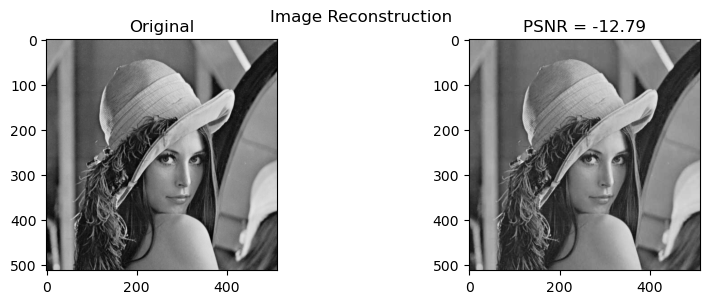

In [ ]:
# Part 5 Quantization

Z = np.array([
[16, 11, 10, 16, 24, 40, 51, 61],
[12, 12, 14, 19, 26, 58, 60, 55],
[14, 13, 16, 24, 40, 57, 69, 56],
[14, 17, 22, 29, 51, 87, 80, 62],
[18, 22, 37, 56, 68, 109, 103, 77],
[24, 35, 55, 64, 81, 104, 113, 92],
[49, 64, 78, 87, 103, 121, 120, 101],
[72, 92, 95, 98, 112, 100, 103, 99]
])

lena = imread('lena2.tiff') * 255
gray_lena = rgb2gray(imread('lena2.tiff')) * 255

# perform the 8×8 DCT transform on the Lena sub-images (remember to subtract 128)
lena_trans5 = np.floor(blockproc(gray_lena - 128, dct_matrix, [8, 8], func))
print(lena_trans5)

def quantize_image(image, Z):
    image_out = np.zeros_like(image)
    for i in range(0, image.shape[0], 8):
        for j in range(0, image.shape[1], 8):
            image_out[i:i+8, j:j+8] = np.round(image[i:i+8, j:j+8] / Z)
    return image_out

def dequantize_image(image, Z):
    image_out = np.zeros_like(image)
    for i in range(0, image.shape[0], 8):
        for j in range(0, image.shape[1], 8):
            image_out[i:i+8, j:j+8] = np.multiply(image[i:i+8, j:j+8], Z)
    return image_out

lena_quantized = quantize_image(lena_trans5, Z)
lena_dequantized = dequantize_image(lena_quantized, Z)

lena_reconstructed = np.floor(blockproc(lena_dequantized, dct_matrix.T, [8, 8], func)) + 128


# plot the reconstructed image and the corresponding PSNR value
plot_images({'Original' : gray_lena, 'PSNR = ' + str(np.round(PSNR(gray_lena, lena_reconstructed),2)): lena_reconstructed}, title='Image Reconstruction')


# Part 6 Convolutional Neural Networks 

In [ ]:
# Part 6 Convolutional Neural Networks
# This part is done in the network.py file
# I have already done this part and added the plots to the report